This is a project using active learning strategies to predict drug-target interactions based on ChEMBL database.

chembl_webresource_client is the official Python client for accessing ChEMBL API. Install this pakcage if not already installed.

In [6]:

%pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# Start a new retrieval from the database
from chembl_webresource_client.new_client import new_client
import pandas as pd

In [8]:
# If you dont't have the CHEMBL_ID of the target of interest, get the CHEMBL_ID first.
target_name ='Angiotensin-converting enzyme'# type the target name here.

# Tested available options are ['Mu opioid receptor', 'Acetylcholinesterase','Histamine H1 receptor'，'Histamine H2 receptor','Muscarinic acetylcholine receptor M1','Angiotensin-converting enzyme','Androgen Receptor','Estrogen receptor alpha']
# Unceratinty sampling works well with 'Histamine H1 receptor',star'Angiotensin-converting enzyme'

# filter those with homo sapiens source and single protein type
targets = new_client.target.filter(pref_name=target_name).filter(organism="Homo sapiens").filter(target_type="SINGLE PROTEIN")
targets = pd.DataFrame.from_dict(targets)

assert len(targets)==1
ID = targets['target_chembl_id'][0]
print('The ChEMBL_ID for this target is:',ID)

 


The ChEMBL_ID for this target is: CHEMBL1808


In [9]:
# Retrieve the assay data for this target
# It usually takes around 3 minutes.
assay_data = new_client.activity.filter(target_chembl_id=ID).filter(standard_type="IC50")

if len(assay_data)>5000:
    assay_data=assay_data.filter(standard_flag=1)

df = pd.DataFrame.from_dict(assay_data)


In [10]:
from data_prep import clean
df=clean(df)

/content/data_prep.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['standard_value'] = df['standard_value'].apply(lambda x: float(x))
/content/data_prep.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plC50']= df['standard_value'].apply(lambda x: np.log10(x))


<Axes: xlabel='bioactivity_threshold', ylabel='count'>

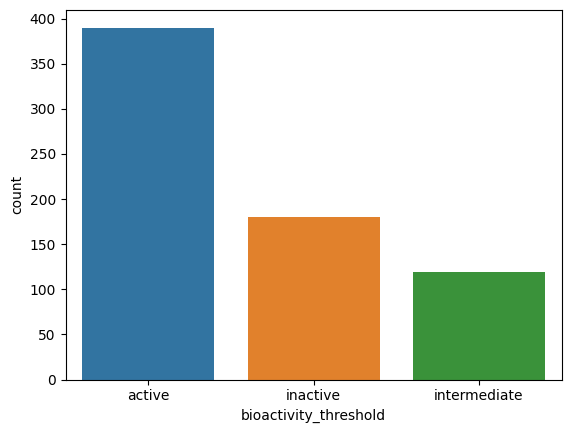

In [11]:
# The IC50 value is the concentration of drug/compound needed to inhibit the target potancy by 50%, so the lower the value the stronger the bioactivity.
# Here we use IC50 values to indicate three levels of interaction between drug and target.
# <1000: to indicate 'active'
# 1000-10000: to inidicate 'intermediate'
# >10000: to indicate 'inactive'
# This is to check that our dataset is not extremely imbalanced.

import seaborn as sns
df['bioactivity_threshold'] = df['standard_value'].apply(lambda x: 'active' if x < 1000 else ('inactive' if x  > 10000 else 'intermediate'))
sns.countplot(x='bioactivity_threshold', data=df)

In [12]:
%pip install rdkit 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 31.8 MB/s eta 0:00:00


In [13]:
# The canonical_smiles of the chemical compounds is what we are concerned about.We use the structural information contained to predict IC50 values.
# Here we transfrom the canonical_smiles into Fingerprints, which is a 2048-bit long 1s and 0s that represents the features of the compounds.
from rdkit import Chem
from rdkit.Chem import AllChem
df['canonical_smiles_mol']= df['canonical_smiles'].apply(lambda x: AllChem.MolFromSmiles(x))
df['canonical_smiles_fingerprints']= df['canonical_smiles_mol'].apply(lambda x: Chem.RDKFingerprint(x))
df.head

<bound method NDFrame.head of     molecule_chembl_id                                   canonical_smiles  \
0         CHEMBL152758          CC(N[C@H](C)C(=O)N1CCC[C@H]1C(=O)O)C(=O)O   
1         CHEMBL291381                        O=C(CCC(=O)N1CCCC1C(=O)O)NO   
2         CHEMBL358439            C[C@@H](NCC(=O)O)C(=O)N1CCC[C@H]1C(=O)O   
3           CHEMBL1237  NCCCC[C@H](N[C@@H](CCc1ccccc1)C(=O)O)C(=O)N1CC...   
4         CHEMBL293213                     CC(CCC(=O)N1CCCC1C(=O)O)C(=O)O   
..                 ...                                                ...   
829      CHEMBL4476621             O=C(NNC(=S)Nc1ccc(Cl)c(Cl)c1)c1ccccc1O   
831       CHEMBL417007  C[C@H](C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)CCC(...   
832      CHEMBL2402203  C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccccc1)...   
833      CHEMBL4590201       O=C(CF)CNC(=O)[C@H](Cc1ccccc1)NC(=O)c1ccccc1   
834      CHEMBL4520267  O=C(CF)CNC(=O)[C@H](Cc1ccccc1)NC(=O)c1cccc2ccc...   

     standard_value     plC50 bioactivity_thr

Configuration

In [14]:
from data_prep import transform
df = transform(df)
n_instance = df.shape[0] # is the number of total instances available 
n_replication = 5 # is the number of times to replicate the active learning protocol to reduce randomness
batchsize = int(0.02*n_instance) # is the number of instances added to training at each round of active learning
print(batchsize)
# Avoid setting the batchsize too big, otherwise batchsize may be bigger than the instances in a cluster when using diversity-based sampling

# if n_instance>=1500: recommend using n_initial = int(0.2*n_instance) & n_keep = int(0.5*n_instance)
# if n_instance<1500: recommend using n_initial = int(0.1*n_instance) & n_keep = int(0.2*n_instance)
n_initial = int(0.1*n_instance) # is the number of instances used for initialize the model
n_keep = int(0.2*n_instance) # is the number of instances left in the pool (not added to training)
n_toadd = n_instance-n_initial-n_keep


13


Round: 0
Running Random Sampling
Running Diversity Sampling
Running Uncertainty Sampling
Round: 1
Running Random Sampling
Running Diversity Sampling
Running Uncertainty Sampling
Round: 2
Running Random Sampling
Running Diversity Sampling
Running Uncertainty Sampling
Round: 3
Running Random Sampling
Running Diversity Sampling
Running Uncertainty Sampling
Round: 4
Running Random Sampling
Running Diversity Sampling
Running Uncertainty Sampling


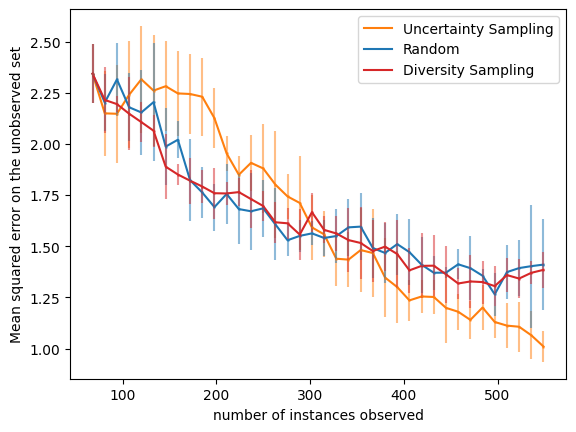

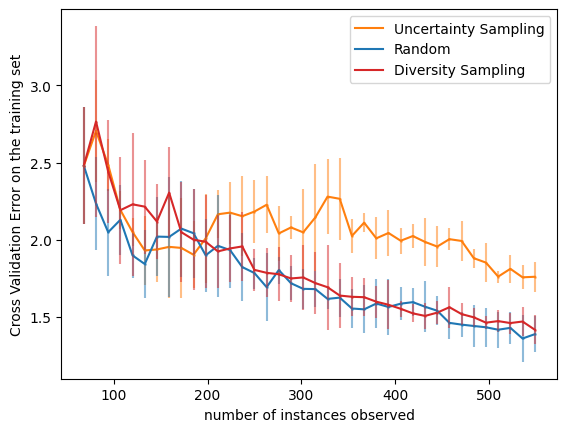

In [15]:
from Simulation import Simulate
result_rand, result_div, result_uns=Simulate(df,n_replication,n_initial,n_toadd,batchsize)

from PlotResult import myplot
# Plot the Mean Squared Errors
myplot(result_rand,result_div,result_uns,n_initial,batchsize,'MSE')

if len(result_rand.CVs)>0:
    myplot(result_rand,result_div,result_uns,n_initial,batchsize,'CV')
# Plot the Cross Validation Scores if available